## Crassus: Development notes
---

In [ ]:
# Python imports
from Bio import SeqIO, SearchIO
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from ete3 import Tree

/home/dani/miniconda3/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/dani/miniconda3/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


#### Test run

`$ mamba create -c bioconda -c conda-forge --name dev_snakemake snakemake snakedeploy singularity` # to run the test\
`$ mamba create -c conda-forge -c bioconda --name utils biopython numpy pandas emboss blast` # env _utils.yaml_ \
`$ mamba create -c conda-forge -c bioconda --name phylogenies mafft trimal fasttree ete3 pandas` # env _phylogenies.yaml_\
`$ mamba create -c conda-forge -c bioconda --name clustering mmseqs2 pandas numpy` # env _clustering.yaml_\
`$ mamba create -c conda-forge -c bioconda --name compare_genomes pandas numpy pyani fastani blast` # env _compare_genomes.yaml_

Singularity pull is not working so far. 

**First big test on 69 complete assemblies (the ancient ones)** \
`(dev_snakemake) danielc@mutant22:[SCREEN]:~/projects/crAssUS:snakemake -j70 --use-conda -p --reason` \
It taks quite a lot of time to download and install the packages of the envs. Maybe because it is a mutant, and I am writing to encode? Let's run it directly fromm the mutant.\
`(dev_snakemake) danielc@mutant23:[SCREEN]:/linuxhome/tmp/danielc/crAssUS:snakemake -j70 --use-conda -p --reason`

This error pops out, rule `get_marker_proteins`:\
`['-', '+'] Baboon22_45_164177_prod-TGA portal                                                                                                                                                              
Traceback (most recent call last):                                                                                                                                                                         
  File "/linuxhome/tmp/danielc/crAssUS/.snakemake/scripts/tmp3kr0o04y.get_marker_genes.py", line 75, in <module>                                                                                           
    print(fragments)                                                                                                                                                                                       
NameError: name 'fragments' is not defined   `

I write a comment on GitHub regarding this. 

Lots of identified contigs seem very distant, ie. they don't cluster with any major family. Mmm what if I do a midpoint rooting? More of this in the `Taxonomy assessing` block.


### Reference crAss set

Originally I used all the genomes that we have (~2k), comprising complete and uncomplete genomes. Besides this might be too much redundancy, classification by ANI would be incorrect for uncomplete genomes. Because of this **I decide to use only the ones listed at `contigs_clustering.xlsx`, with the complete and taxonomically classified genomes from the proposal**. Using type species would be too few though. 

So, I change the whole reference set to include in the the container. 846 complete crAss genomes (excluding crass-env) in `contigs_clustering.xlsx`, but I still add the reference Bas' crass (crass001 is already in the list) and the two outgroups, so it makes 849 at the end. I change the .fasta files under `/genomes` and the proteins in `all_crass_proteins.faa` according to this. ⚠️ **WARNING** ⚠️ Because of the lack/split of TerL gene in 8 genomes, the final number is 841, read below.

Regarding the terminases, I extract them with Biopython. I grab all the trimmed, merged terminases from `bas/february_2021/terLterL_sequences_trimmed_merged.faa`:

In [20]:
# read "crassus_genomes.txt" with the target genomes ids
target_genomes = [line.strip() for line in open("crassus_genomes.txt").readlines()]

# read the .faa file with all the terminases. Store the ones from the target genomes
to_write = list()
records = SeqIO.parse("container/terL_sequences_trimmed_merged.faa", "fasta")
for record in records:
    genome = record.id.split("|")[0]
    if genome in target_genomes:
        to_write.append(record)
        target_genomes.remove(genome)
        
with open("container/crass_reference_TerL.faa", "w") as fout:
    SeqIO.write(to_write, fout, "fasta")
                
# print genomes without a final TerL protein 
print(target_genomes)
len(target_genomes)

['3300008523_____Ga0115231_1000095', 'OAWB01000083', '3300014553_____Ga0134451_100057', 'ERR589831_NODE_127_length_97341_cov_28.7607', 'OLOZ01000093', 'OLQU01000060', 'ERR589503_NODE_260_length_95985_cov_44.2112', 'ERR589804_NODE_183_length_96082_cov_14.9851']


8

Note well the 8 genomes without a TerL gene. **I remove them from the reference set so far**. 

In [21]:
# remove them from the genomes folder
for genome in target_genomes:
    if os.path.isfile(f"container/genomes/{genome}.fasta"):
        print(f"deleting {genome} genome")
        os.remove(f"container/genomes/{genome}.fasta")
        
# remove them from `all_crass_proteins.faa` 
to_write = list()
records = SeqIO.parse("container/all_crass_proteins.faa", "fasta")
for record in records:
    genome = record.id.split("|")[0]
    if genome not in target_genomes:
        to_write.append(record)

with open("container/all_crass_proteins.faa", "w") as fout:
    SeqIO.write(to_write, fout, "fasta")

---
### TerL tree + rest of the trees (MCP, portal?, primase?)

The reference set are 841 genomes with their proteins and terminases. I don't know how long is gonna take to align all these sequences + the sequences found by the pipeline.

`mafft-einsi` took 15 mins with 841 seqs and 93 CPUs.
- `(mafft_env) danielc@mutant5:/linuxhome/tmp/danielc/crassus_terl:time mafft-einsi --thread 93 --quiet crass_reference_TerL.faa > crass_reference_TerL.mafft-einsi`

Let's parse the tree. I want to get as much classification as I can from it. The approach I follow is looking at two uppper nodes and checking if the family/subfamily/genus is the same.

`fasttree` was quick making the tree ofc. But what about iqtree in its fastest mode? Let's run it with the reference genomes to know how long it takes and to measure the distances inter and intra genera.\
`(iqtree) danielc@mutant5:[SCREEN]:/linuxhome/tmp/danielc/crassus_terl:time iqtree -fast -T 90 -s crass_reference_TerL.mafft-einsi -B 1000 -alrt 1000`

One of the drawbacks I see is the model estimation takes too long.


Time to get the sequences for the rest of the markers. Let's start with **MCP**. This is a very split gene, but it should be easy to get it full-length since I already merged them based on the merge/leave analysis. Just look at the `3_merged` genome tables. Script `borrar/mcp/gather/mcps.py`. Most of them are OG_824 & OG_825:

1109 OG_824\
565 OG_825\
133	OG_827\
84	OG_669\
17	OG_826\
10	OG_223\

Get the MCPs faa:\
`(base) danielc@encode:~/borrar/mcp:python get_mcps.py`

Align it:\
`(mafft_env) danielc@mutant5:~/borrar/mcp:mafft-einsi --thread -1 MCP_crassphage_reference.faa > MCP_crassphage_reference.mafft-einsi`


---
### mmseqs2 clustering

I already have implemented most of it, but still have to assess the cutoff values to delimitate genera. In the proposal it is 80% of shared content using OrthoMCL. 

Last time I tried to calculate this shared content for all the genomes, but it was too intensive for my computer/CPUs, the matrix is too big to fill it in a reasonable amount of time. However, I wrote a multithreaded script for this long time ago, `create_shared-content_from_presabs.py`. Diretory `/home/danielc/borrar/shared_content` under encode, I copy all the files there.

`(base) danielc@mutant5:~/borrar/shared_content:python create_shared-content_from_presabs.py -i presabs_matrix.txt -f all_proteins.faa -o shared_content_all.txt`

Let's plot the results 

In [ ]:
# read taxonomy file and save it in a dict
crass_taxonomy = dict()

tax_file = "container/crass_taxonomy.txt"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]
for line in lines:
    crass_taxonomy[line[0]] = {
                               "family":line[2],
                               "subfamily":line[3],
                               "genus":line[4]
                              }


# get the order of the gneomes in the tree
tree_file = "results/6_terl_tree/terl_tree.nwk"
t = Tree(tree_file, format=1)
#t.show()
# find the LCA of the two outgroup species
outgs_leaves = t.search_nodes(name="NC_021803|775|90") 
outgs_leaves += t.search_nodes(name="TARA_MK892509|880|3")
outgs_lca = t.get_common_ancestor(outgs_leaves)
# reroot the tree 
t.set_outgroup(outgs_lca)
# iterate the leafs and store the order
tree_order = list()
for leaf in t.iter_leaves():
    genome = leaf.name.split("|")[0]
    tree_order.append(genome)

tree_order[:10]

['NC_021803',
 'TARA_MK892509',
 'Baboon19_4536_18809',
 'Baboon36B_45_178529',
 'Baboon36B_89_150636',
 'Baboon22_44_164225',
 'Baboon36B_435_75811',
 'Chimp25_15_167338',
 'Lemur8_27_148801',
 'OCHL01000028']

In [ ]:
# read the shared content table and re-order it according to the tree
matrix_file = "/home/dani/encode_home/borrar/shared_content/shared_content_all.txt"
df = pd.read_csv(matrix_file, sep="\t", index_col=0)

# reorder columns
df = df[tree_order]
# reorder rows
df = df.reindex(tree_order)

In [12]:
df.loc["ERR589440_NODE_115_length_101302_cov_10.743",:]

11_lib200753_1                                            0.07
16T1_lib200772_4                                          0.04
16T1_lib200772_5                                          0.05
17T1_lib200766_2                                          0.06
17T1_lib200766_3                                          0.03
                                                          ... 
mac_M1_k141_NODE_211721_flag0_length_94826_cov_60.0000    0.07
mac_M3_k141_NODE_17659_flag3_length_96717_cov_27.9938     0.07
pig_E3_k141_NODE_91221_flag1_length_92815_cov_13.0000     0.02
pig_E4_k141_NODE_127021_flag3_length_98667_cov_58.0000    0.05
pig_E6_k141_NODE_109023_flag3_length_97886_cov_44.0000    0.05
Name: ERR589440_NODE_115_length_101302_cov_10.743, Length: 854, dtype: float64

Colors of the heatmap in the proposal are from the **Spectral** R palette, which is not available in Matplotlib. To get the color codes, I use [this](https://gist.github.com/jtoll/4021792) running R directly in the encode's shell (since I don't have R installed in my Toshiba right now).

Colors are below. Remove first and last and you are ready to go (9 colors + white of 0-10% of shared content):\
"#9E0142", "#D53E4F", "#F46D43", "#FDAE61", "#FEE08B", "#FFFFBF", "#E6F598", "#ABDDA4", "#66C2A5", "#3288BD", "#5E4FA2"

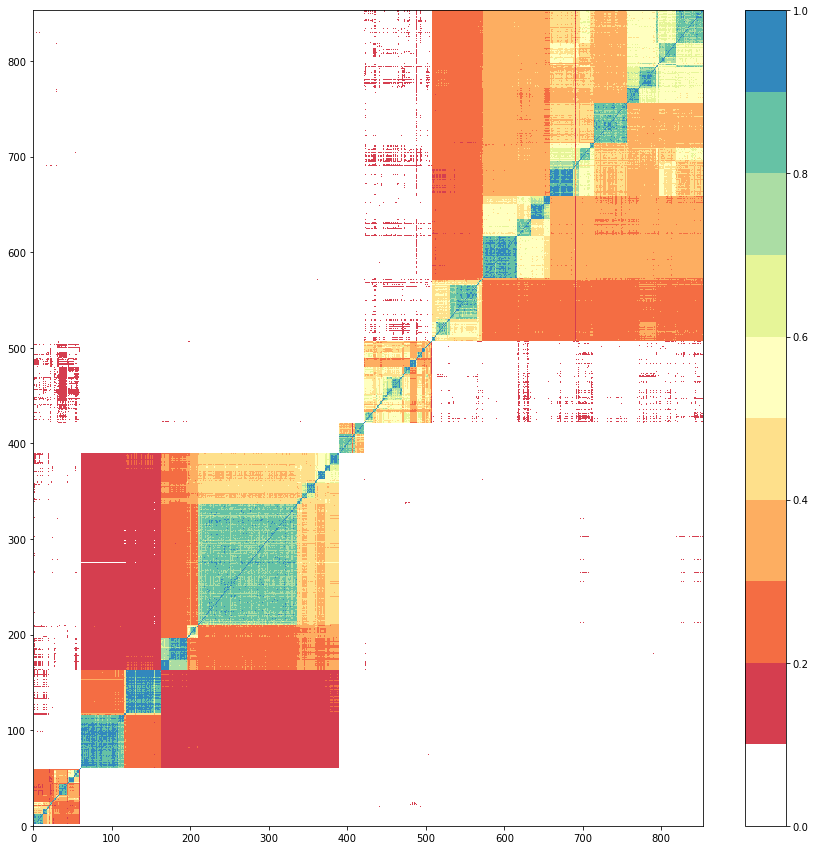

In [88]:
# draw the heatmap
cmap = colors.ListedColormap(["white", "#D53E4F", "#F46D43", "#FDAE61", "#FEE08B", "#FFFFBF", "#E6F598", "#ABDDA4", "#66C2A5", "#3288BD"])
bounds= np.arange(0,1, 0.1).tolist()
plt.rcParams["figure.figsize"] = (15,15)
heatmap = plt.pcolor(df, cmap=cmap)
plt.colorbar(heatmap, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])

Heatmap shows that, in overall, values of shared protein content are lower than in the proposal. This agrees with what I saw of mmseqs2 being less sensitive than Broccoli, ie. creating more clusters. This should not be a problem as long as I find a proper cutoff to delimitate genera with this approach. 

I want to check 3 things:
- minimum value of sharing within the same genus
- maximum value of sharing between different genera

In [116]:
# store the shared content values within the same genus and between different genera
within_genus   = list()
between_genera = list()

# compute it only for the ref crassphages, discard output and found by crAssUS
genomes = [genome for genome in df.index.tolist() if genome in crass_taxonomy and genome not in ["NC_021803", "TARA_MK892509"]]

for query in genomes:
    for ref in genomes:
        if crass_taxonomy[query]["genus"] == crass_taxonomy[ref]["genus"]:
            within_genus.append(df.loc[query, ref])
        else:
            between_genera.append(df.loc[query, ref])
            
# put everything in the same df
dataset = ["within_genus"] * len(within_genus) + ["between_genera"] * len(between_genera)
values  = within_genus + between_genera
to_df = [[kind, value] for kind, value in zip(dataset, values)]

In [130]:
df_sharedc = pd.DataFrame(to_df, columns=["dataset", "value"])
df_sharedc

,dataset,value
0,within_genus,1.00
1,within_genus,0.91
2,within_genus,0.87
3,within_genus,0.84
4,within_genus,0.88
...,...,...
703916,between_genera,0.60
703917,between_genera,0.59
703918,between_genera,0.60
703919,between_genera,0.62


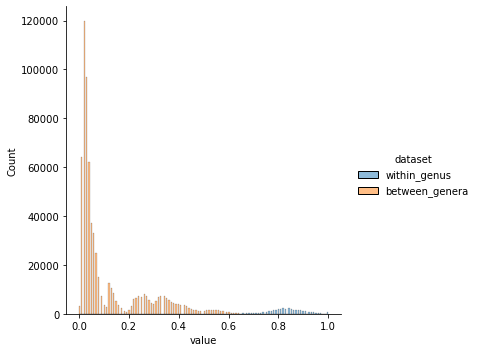

In [132]:
sns.displot(df_sharedc, x="value", hue="dataset")

(0.0, 2000.0)

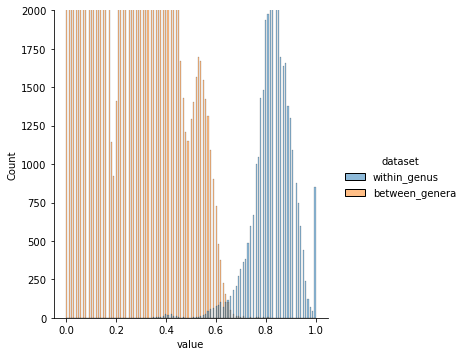

In [134]:
sns.displot(df_sharedc, x="value", hue="dataset")
plt.ylim(0, 2000)

---
### Draw genomes

Let's do something more relaxing, let's draw the genomes' alignments. BioPython GenomesDiagram's are ugly as fuck, so let's give it a try to gnoplotr. That means that I need to install R, both in my toshiba and the container. For the toshiba I follow [this link](https://linuxize.com/post/how-to-install-r-on-ubuntu-20-04/), for the container I use mamba for the version 4.1. Development under the `genomes_graphs_dev` folder, Rnotebook. ⚠️ **too shity** ⚠️ Let's move with the next method.

I was trying to avoid EasyFig, but it might be my best shot. It can be run from the command line too.

**I ask Petros about a package for this: he says there is one actually, but is busy right now and will send it to me later.** Well, the package is [clinker](https://github.com/gamcil/clinker/blob/master/images/figure.png). It might be nice, but first drawback is that it needs genbank files. 

Let's move forward with `genoplotR` for now. This is what I will need:

1) Which kind of alignment should I expect from Blast? 

x) Reorder genomes to make them start from the terminase gene. **What if the genome found does not contain a terminase?**

---
### Taxonomy assessing

I have some difficulties using singularity containers for this. NB that I need an environment with ete3 and a file with the taxonomy for the reference crassphages. It seems that the `container` directive does not work well with the `script` one, since I am not able to import ete3 using the latter. However, it works using a conda environment instead.

`mamba create -c conda-forge -c bioconda -c etetoolkit -n ete3_env ete3`\
`conda env export --name ete3_env > ete3_env.yaml`

Some of the TerL identified in the big test (all the ancient, monkeys samples) seem to be very distant. Maybe even more than the two usual outgroups. 

- TerL tree of the 841 species in `TerL_crassphage_reference.mafft-einsi`. I do it with FastTree so far. **midpoint rooting of this tree(**`TerL_crassphage_reference.nwk`) **places the two outgroups outside of the crAss clade**.

- TerL tree of ALL the crassphages of my project, from `february_2021`. 

It is fine, after a meeting with Bas we agree that the outgroup is not that important. Maybe we find even better outgroups, ie. more distant. So, let's continue using the outgroups from Yutin. 

Something I notice is that what I called "Approach 2" in `parse_terl_tree.ipynb` fails in very populated clades with new contigs only because this approach only loos 2 nodes up. Look for instance at these new genomes, they should be annotated at least as _Steigviridae, Asinivirirane_, but are left blank. 

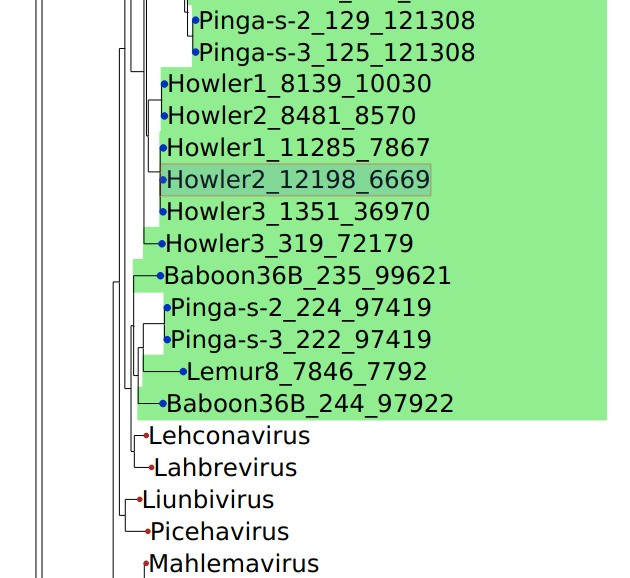

So, the only thing I can think of is following the Approach 1, where I find the LCA for each rank and then the new genomes that fall within each of them. BUT for that each of the ranks has to be monophyletic. I recall there were some that were not. To check that everything is fine with the tree, I build one only with the references and IQtree.

`(iqtree) danielc@mutant5:[SCREEN]:/linuxhome/tmp/danielc/crassus_terl/normal:time iqtree -T 90 -s crass_reference_TerL.mafft-einsi -B 1000 -alrt 1000`

Actually, I think it would be better not doing something weird changing the taxonomy (doing Uncouvirinae_1 and so) and just annotate the inner nodes. Then, for each of the new genomes, go deeper in the tree until the family/subfamily/genus agrees. **I realize that I need to know where the LCA of a genus (for instance, applies to all ranks) is. With the so-called _aproach 3_ I don't how to discern between two scenarios: new genome within a genus clade, and new genus being the sister clade of a genus clade. When looking at the upper node, in both scenarios is gonna be [genus, "new"]. So I can not say "yeah if in the childs contain only genus X and a new genome, call it as genus X too".** \
So, I need monophylectic clades. Changes to the taxonomy are under `/home/danielc/projects/crAssUS/resources/terl_fixed_monophyl_tax.txt`. Notice that the same needs to be done for the MCP. Let's go for it. Done. Now the same for the portal:

- Genomes OHFV01000001, OLXR01000011, QRFC01000022, TARA_MK892509 and NC_021803 were not annotated with the portal profile:
    - **NC_021803**, portal is NC_021803|812|91	OG_2062
    - **TARA_MK892509**, portal is TARA_MK892509|808|5 OG_2062
    - **OHFV01000001**, portal is OHFV01000001|734|116
    - **OLXR01000011**, portal is OLXR01000011|734|207
    - **QRFC01000022**, portal is QRFC01000022|734|190 
    
For the genomes where more than one portal is found, grab only **OG_48**. 844 at the end of the process. 

`(mafft_env) danielc@encode:~/borrar/portal:mafft-einsi --thread 10 portal_crassphage_reference.faa > portal_crassphage_reference.mafft-einsi`

Let's see how fucked up the monophylic clades are in the portal tree. Not that much :)

The result of cell above is a table called `taxonomic_classification_completeness.txt` with the taxa classifications based on the marker's trees. Now I have to **figure out how to use the protein sharing information**. 

---
### Genomes completeness

Given that I am using just a 5Kb filter, I need a way to assess the completeness of the contigs. 

From Yutin 2021: _To limit the analyzed dataset to complete, fully assembled genomes, 95,663 “circular” contigs (50–200 bp direct overlap at contig ends) were extracted from the assemblies._ So a good initial step could be assessing if they are **DTR** complete or not. Rule `run_DTR_blast`

**Idea:** _What if I calculate the average length (with standar deviation etc) and assess the completeness based on the number of the highest rank that I could assign? If it is genus, I calculate the completeness based on that genus; if it is subfamily, based on the subfamily; and so on_

I run checkV on my contigs

I add a rule to get the distances in the tree, only for the crAssUS contigs tho. **Why did I want to do this? I think that as a measure of replacing the current taxonomic classification with the trees**

Get the average length, per rank:

In [26]:
# read taxonomy file and save it in a dict
# parse genome length too
crass_taxonomy = dict()

tax_file = "container/crass_taxonomy.txt"
genome_dir = "container/genomes"
lines = [line.strip().split("\t") for line in open(tax_file).readlines()]
for line in lines:
    fasta_genome = f"{genome_dir}/{line[0]}.fasta"
    if os.path.isfile(fasta_genome):
        record = SeqIO.read(fasta_genome, "fasta")
        length = len(record.seq)
        crass_taxonomy[line[0]] = {
                                   "family":line[2],
                                   "subfamily":line[3],
                                   "genus":line[4],
                                   "length":length
                                  }

# get all the different ranks so I can store their average lengths
taxas = list()
for genome, ranks in crass_taxonomy.items():
    for rank in ranks:
        if rank != "length":
            taxas.append(crass_taxonomy[genome][rank])

taxas = list(set(taxas))

# iterate the crass_taxonomy dict and store the lengths for each taxa, these being the keys this time
taxas_lengths = {taxa:list() for taxa in taxas}
for genome, ranks in crass_taxonomy.items():
    for rank in ranks:
        if rank != "length":
            taxas_lengths[crass_taxonomy[genome][rank]].append(crass_taxonomy[genome]["length"])

with open("resources/taxas_average_length.txt", "w") as fout:
    for taxa, lengths in taxas_lengths.items():
        average = np.average(lengths)
        fout.write(f"{taxa}\t{average}\n")

---
### Branch and merge

I want to play with this. Let's refactor de pipeline, brach **refactor**. 

\# create branch and move to it\
`$ git checkout -b refactor`

\# change the stuff I want to change and commit it\
`$ git add .gitignore dev_notes.ipynb workflow/Snakefile workflow/rules/`\
`$ git commit -m "refactor initial rules"`

Then I just merged with master, but I didn't push before it. Just because I didn't need it. Basically I followed this [link](https://git-scm.com/book/en/v2/Git-Branching-Basic-Branching-and-Merging).  

---
### Genomes comparisons

So. time for the fastANI & PyANI thing. Running it is easy, I alreadh have it implemented. The tricky part is what to do with it, as with the sharing information. One thing to do for sure is plotting to the most similar genome. 
I pick the most covering genome given by PyANI, and run megablast with it. To show the results, I need a file in the format of the genome tables that I have for my main project. For the found genomes, I create it with the script `create_genome_tables.py`, rule `create_genome_table` from `open_reading_frames.smk`. Now I need genome tables for the reference genomes, present in the `resources/genomes` folder. Script `create_ref_genomes_tables.py`. I just read the genome tables I already have for them and grab the specific columns I need.

Mmm I am not happy with how PyANI and megablast analyses are connected, with dummy `.done` files. This might be problematic in the future, but it also difficult to put in in a checkpoint because the output is not a folder but specific files. Maybe it is possible with checkpoints, but I could not see how (so far). I notice that actually all the samples can go through PyANI because there will be always a selfhit since I am using all the genomes as a database, including the genome itself. So, no need to checkpoints for avoiding PyANI fail. Same with megablast, I can blast it to itself with no problem.



    


## TESTS

In [112]:
a = [1,2,3,4]
b = [5,6,7,8]
c = a+b
x = ["first"] * len(a)
y = ["second"] * len(b)
z = x+y
j = pd.DataFrame("set":z, "values":c

SyntaxError: invalid syntax (2926451594.py, line 7)

In [124]:
penguins = sns.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female
